In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from preprocess_ecg_data import load_ecg_data
from scipy.fft import fft, rfft, fftfreq, fftshift, dct
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.stats import zscore

ECG_LEN = 65536
ECG_WINDOW = 2000
F_SAMPLING = 128

F_MAX = F_SAMPLING/2
N_TOP_FREQ = 5
BPM_2_1HZ = 60

PATH = './ECGData.mat'

In [2]:
# Download heartpy library
# !python -m pip install heartpy

## __Task 0: Data preprocessing__

First, we preprocessed the data by taking the 162 samples of length 65536 and divide it in subsamples of length 2000, "windowing" the data. This resulted in a dataframe that had, for each entry:
* A sample of length 200.
* The class of the subsample, wether is ARR (Arrhythmia), CHF (Congestive heart failure) or NSR (Normal sinus rhythm).
* Where was each subsample originally obtained.
* Which n-th chunk of the original sample was the subsample from (1-32).

Also, we defined the following label map: 
* #####    1:ARR (Arrhythmia)
* #####    2:CHF (Congestive heart failure)
* #####    3:NSR (Normal sinus rhythm)

In [3]:
ecg_data = load_ecg_data()

df_ecg_data = pd.DataFrame(ecg_data)
df_ecg_data 

,ecg_data,class,sampled_from,n_chunk
0,"[-0.09785730141312626, -0.15688125766870917, -...",1,1,1
1,"[-0.3484112418649029, -0.02274587725720959, 0....",1,1,2
2,"[-0.4360649375168176, -0.4460280919950408, -0....",1,1,3
3,"[-0.38340009514361517, -0.38383578522187806, -...",1,1,4
4,"[-0.3231552247831461, -0.3163997523002529, -0....",1,1,5
...,...,...,...,...
5179,"[-0.265, -0.265, -0.265, -0.185, -0.085, 0.275...",3,36,28
5180,"[0.065, 0.055, 0.135, 0.225, 0.275, 0.325, 0.3...",3,36,29
5181,"[-0.345, -0.365, -0.355, -0.355, -0.375, -0.34...",3,36,30
5182,"[-0.005, 0.035, -0.045, 0.045, 0.015, -0.035, ...",3,36,31


In [4]:
df_ecg_data[(df_ecg_data['sampled_from'] == 30) & (df_ecg_data['class'] == 3)]

,ecg_data,class,sampled_from,n_chunk
4960,"[-0.425, -0.415, -0.405, -0.405, -0.395, -0.38...",3,30,1
4961,"[0.315, 0.315, 0.305, 0.305, 0.295, 0.285, 0.2...",3,30,2
4962,"[-0.015, -0.015, -0.005, -0.015, -0.015, -0.00...",3,30,3
4963,"[0.005, 0.195, 0.205, -0.135, -0.645, -0.625, ...",3,30,4
4964,"[0.055, 0.045, 0.035, 0.015, 0.015, -0.005, -0...",3,30,5
4965,"[0.055, 0.095, 0.065, 0.055, 0.055, 0.065, 0.0...",3,30,6
4966,"[0.015, 0.015, 0.015, 0.005, 0.065, 0.195, 0.2...",3,30,7
4967,"[0.005, 0.015, 0.015, 0.015, 0.025, 0.035, 0.0...",3,30,8
4968,"[0.035, 0.035, 0.045, 0.035, 0.035, 0.025, 0.0...",3,30,9
4969,"[0.305, 0.225, -0.075, -0.475, -0.305, -0.085,...",3,30,10


In order to visualize one ECG from our dataset, we created a sample array. Since we know that the sample frequency was 128 hertz, we could create an array of length 2000 with 1/128 intervals.

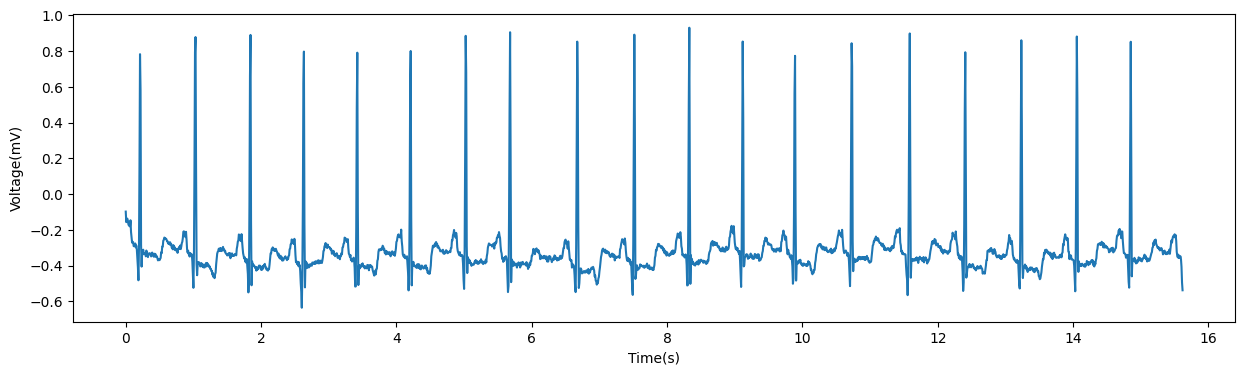

In [5]:
t_values = np.arange(0, ECG_WINDOW * 1/F_SAMPLING, 1/F_SAMPLING)
plt.figure(figsize=(15, 4))
plt.plot(t_values, df_ecg_data['ecg_data'][0])
plt.xlabel("Time(s)")
plt.ylabel("Voltage(mV)")
plt.show()

And there we have our ECG sample plotted.

## __Task 1: Measuring the Heart rate from ECG signals.__

For this task take only ECG samples number 1 and 36 with the label NSR (normal sinus rhythm). For each of the two ECG examples divide the signal into windows of 2000 samples without overlapping. The remaining samples at the end of the file can be discarded.

In [6]:
# Taking the sample 1 and 36 from the NSR
df_ex1 = df_ecg_data[(df_ecg_data['class'] == 3) & ((df_ecg_data['sampled_from'] == 1) | (df_ecg_data['sampled_from'] == 36))]
df_ex1


,ecg_data,class,sampled_from,n_chunk
4032,"[-0.165, -0.155, -0.195, -0.205, -0.185, -0.15...",3,1,1
4033,"[-0.175, -0.175, -0.175, -0.175, -0.215, -0.18...",3,1,2
4034,"[2.235, 2.705, 2.525, 1.205, -0.255, -0.405, -...",3,1,3
4035,"[-0.095, -0.105, -0.115, -0.105, -0.095, -0.08...",3,1,4
4036,"[-0.125, -0.145, -0.165, -0.125, -0.065, -0.10...",3,1,5
...,...,...,...,...
5179,"[-0.265, -0.265, -0.265, -0.185, -0.085, 0.275...",3,36,28
5180,"[0.065, 0.055, 0.135, 0.225, 0.275, 0.325, 0.3...",3,36,29
5181,"[-0.345, -0.365, -0.355, -0.355, -0.375, -0.34...",3,36,30
5182,"[-0.005, 0.035, -0.045, 0.045, 0.015, -0.035, ...",3,36,31


The goal was to obtain the average heart rate for each of the windows considered using for this the analysis of the FFT (Fast Fourier Transform).
We assumed that each ECG sample is provided by two different persons. Therefore, we plotted an histogram for the average heart rate of the windows for each ECG separately.

In [7]:
ft = df_ex1['ecg_data'].apply(lambda x: fftshift(fft(x)))
freq = df_ex1['ecg_data'].apply(lambda x: fftshift(fftfreq(x.shape[-1])))

# stack squeezes the dimensions of each entry in the pandas series. If we 
# have an array of N entries, each of one with an array of M values, this 
# operation will squeeze it to a matrix of N*M
np.stack(ft.values).shape

(64, 2000)

In [8]:
# we remain with the positive frequencies
halve_array = lambda x: x[int(len(x)/2):]

# apply the FFT to each of the 2000 windows
ft = np.stack(df_ex1['ecg_data'].apply(lambda x: fftshift(fft(x))).values)
freq = np.stack(df_ex1['ecg_data'].apply(lambda x: fftshift(fftfreq(x.shape[-1]))).values)

freq.shape

(64, 2000)

Now, as we can see, the fft function of python gave us the whole range of frequencies (positives and negatives) normalized between $-1/2 \geq f \geq 1/2$. Since we only want the positive range of the frequencies, we are going to halve both the values of the fourier transform (`ft`) and the frequency index (`freq`) arrays. We also tried to use the `rfft` function from the `scipy` package, but this would not get better results for us, as the frequency axis was already cut in half, and the frequency was not normalized between $-1/2$ and $1/2$.

In [9]:
# we only get the positive frequencies
ft_positive = np.apply_along_axis(halve_array, axis=1, arr=ft)
freq_positive = np.apply_along_axis(halve_array, axis=1, arr=freq)

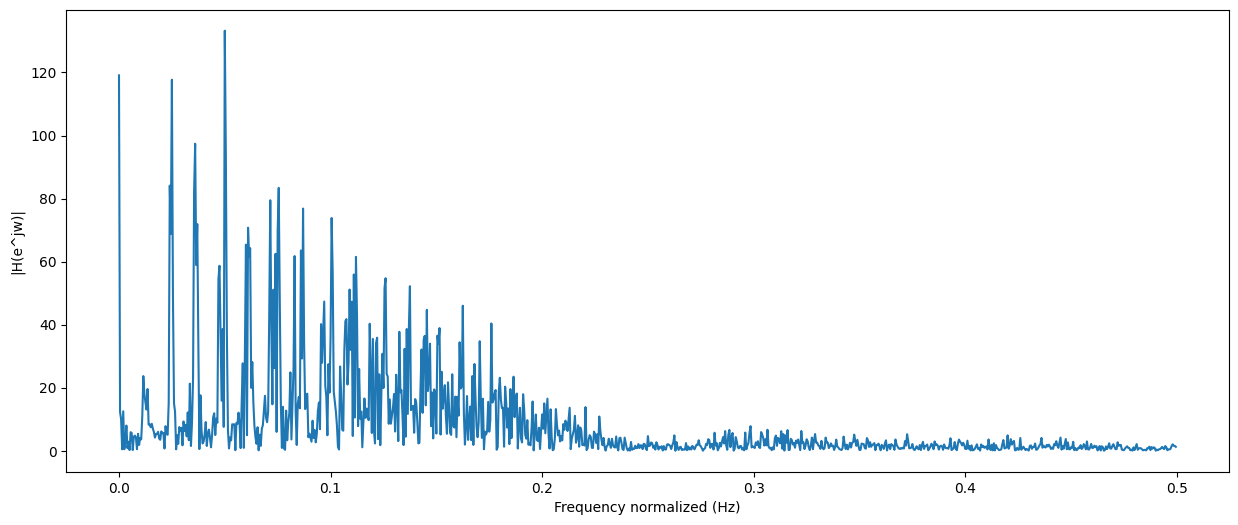

In [10]:
sample=1

ft_sample = abs(np.array(ft_positive)[sample].real)
freq = np.array(freq_positive)[sample]
plt.figure(figsize=(15, 6))
plt.plot(freq, ft_sample)
plt.xlabel('Frequency normalized (Hz)')
plt.ylabel('|H(e^jw)|')
plt.show()

Now, we have only the positive range of values of our fourier transform.

We had another issue with this dataset, and it is the fact that, from the fourier transform, we only get the normalized frequencies, but our dataset was collected by sampling with a frequency of 128 Hz.

Following the Nyquist sampling theorem, a optimum frequency sample should follow the formula:

$$
f_s \geq 2 * f_{max}
$$

If we suppose that the frequency of sampling for this dataset follows this theorem, and $f_s=128$, then, the $f_{max}$ should be equal to 64. This means that, the higher frequency of the ECG, would suposedly be 64 Hz, and from that point, we could infer the rest of the frequencies from the normalized scale to the original one. Once we have done this, we convert the frequencies to BPM (by multiplying by 60, since 1hz -> 60BPM) and we would obtain our frequencies in the BPM domain.



### __1.1 Computing one bpm__

The objective is to obtain the distance between two peaks followed by the signal in frequency to obtain the bpm

To calculate the peaks, the find_peaks function is used, defining two variables: a threshold (HEIGHT) and a minimum distance between peaks.
* If the distance between the peaks is greater than 45 samples, it means that there is a peak below the defined threshold. The solution is to recalculate the peaks by decreasing the threshold.
* If the distance between the peaks is less than 20 samples, it means that the same peak is being detected in several samples. To avoid this, the peaks are recalculated by increasing the distance between peaks.

To calculate the heart rate, the following formula is used:

$$
BPM = peaks * constant * 60, 
$$

where the $constant$ is $f_{max} / T_{samples}$ = 64/1000 (Hz/samples); the peaks the value of the sample where the peak is (samples), and 60 the conversion to minutes.


In [11]:

HEIGHT=max(ft_sample)*0.30
print(HEIGHT)
peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=15)
print(peaks[0:5])

if peaks[0]>=45:                # Si la distancia entre picos es muy grande es que el umbral esta por encima de un pico por lo que se baja el umbral
    HEIGHT=max(ft_sample)*0.10
    print(HEIGHT)
    peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=20)
    print(peaks[0:5])

if peaks[0]<=20:                # Si la distancia entre picos es muy pequeña es que se estan detectando dos picos seguidos por lo que se aumenta la distancia entre picos
    peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=40)
    print(peaks[0:5])

frec=64/1000   # regla de tres si 0.5Hz normalizados => 64Hz (T Nyquist) => 1000 muestras
                #                                       BPS              => peaks[0] muestras
print(frec)

BPM=peaks[0]*frec*60    # peaks[0]*frec (BPS) x 60 = BPM
print(BPM)

39.972527500541936
[ 50  72 100 122 151]
13.32417583351398
[ 23  50  72 100 122]
0.064
88.32


To calculate the heart rate of users 1 and 36, a loop is used to calculate the 32 samples for each user, with a mean of 64 bpm.

In [12]:
bpm=np.zeros(len(ft_positive))
peaks0=np.zeros(5,)
peaks1=np.zeros(5,)


for i in range(len(ft_positive)):
    ft_sample = abs(np.array(ft_positive)[i].real)
    freq = np.array(freq_positive)[i]
    
    HEIGHT=max(ft_sample)*0.30
    #print(HEIGHT)
    peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=15)
    peaks0=peaks[0:5]
    #print(peaks[0:5])
    if peaks[0]>=45:
        HEIGHT=max(ft_sample)*0.10
        #print(HEIGHT)
        peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=20)
        #print(peaks[0:5])
        peaks0=peaks[0:5]
        peaks1=peaks[0:5]

    if peaks[0]<=20:
        peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=40)
        #print(peaks[0:5])
        peaks1=peaks[0:5]

    frec=64/1000
    

    #print(frec)
    if (peaks1[0]<=20):
        BPM=peaks0[0]*frec*60
          
    else:
        BPM=peaks1[0]*frec*60

    bpm[i]=BPM

print(bpm) # 64 bpm = 32 bpm of the user 1 and 32 bpm of the user 36

[ 96.    88.32  96.    96.    96.    96.    96.    96.    96.    96.
  96.    96.    96.    92.16  92.16  92.16  92.16  92.16  92.16 111.36
 111.36 107.52 107.52   7.68 115.2  115.2   99.84 107.52 111.36 111.36
 115.2  126.72  65.28  69.12  11.52  65.28  65.28  11.52   7.68   7.68
   7.68   7.68  26.88  57.6   57.6   61.44  65.28  15.36  80.64  80.64
  69.12  65.28  61.44  61.44 126.72  61.44  69.12 126.72 138.24  46.08
   7.68  19.2  149.76  49.92]


Once the bpm of both users have been obtained, the histograms of each user have been represented in two individual graphs in blue and the average heart rate in red.

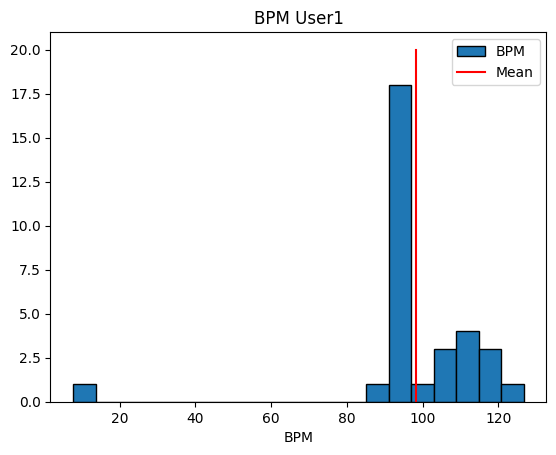

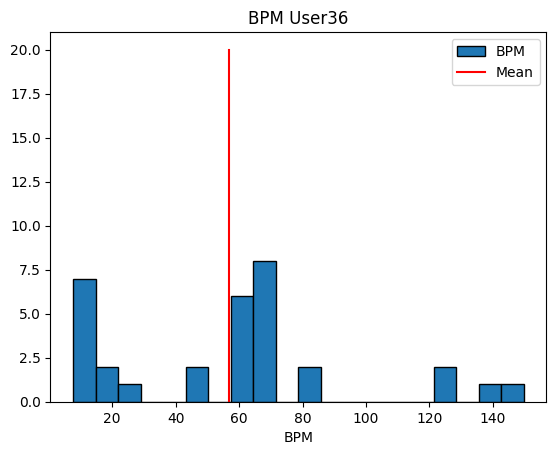

In [13]:
# Histogram
user1=bpm[0:32]
user36=bpm[32:64]

# mean
mean1=np.mean(user1)
mean36=np.mean(user36)

# Histogram user1
fig, ax = plt.subplots()
ax.hist(user1, bins=20, edgecolor = "black", label="BPM")
ax.plot([mean1,mean1], [0,20], color = "red", label="Mean")
ax.legend()
ax.set_title("BPM User1")
ax.set_xlabel('BPM')
#ax.set_ylabel('Value')
plt.show()

# Histogram user 36
fig, ax = plt.subplots()
ax.hist(user36, bins=20, edgecolor = "black", label="BPM")
ax.plot([mean36,mean36], [0,20], color = "red", label="Mean")
ax.legend()
ax.set_title('BPM User36')
ax.set_xlabel('BPM')
#ax.set_ylabel('Value')
plt.show()



## __Task 3: Classification of ECG signals.__

* Let’s consider a balanced problem with the same number of examples per class. We will consider the first 30 ECG examples per class in this task.
* Divide the data into training and test sets considering the first 21 examples of each class for training and the remaining 9 examples per testing.
* Then remember that each ECG signal will be further divided into time windows with length 2000 samples without overlap. Each time window will be considered as a new example in the database.
* The objective of this task is to develop a system to automatically classify between the three types of ECG signals in the database. The measure to maximize is the accuracy.

In [14]:
ecg_data = load_ecg_data()
df_ecg_data = pd.DataFrame(ecg_data)

### __3.1 Feature extraction__

In our case, we opted for using the FFT, the DCT over the FFT and some local and global features such as:
* Local Features: first derivatives and second derivatives
* Global Features: Avg distance between peaks, std deviation of distance between peaks, average heart rate, max heart rate, min heart rate... ect.

#### __3.1.1 Local Features extraction__: First derivatives and second derivatives

In [15]:
df_ecg_data['deriv1'] = df_ecg_data['ecg_data'].apply(lambda x: np.gradient(np.array(x)))
df_ecg_data['deriv2'] = df_ecg_data['deriv1'].apply(lambda x: np.gradient(np.array(x)))

#### __3.1.2 Global Features extraction__: Avg distance between peaks and number of heartbeats

This was one of the trickiest part in the preprocessing analysis. Obtaining the peaks of each of the ecgs was difficul since a lot of different topologies in the different signals appeared. For example, in the following ECG, it is quite easy to find the peaks:

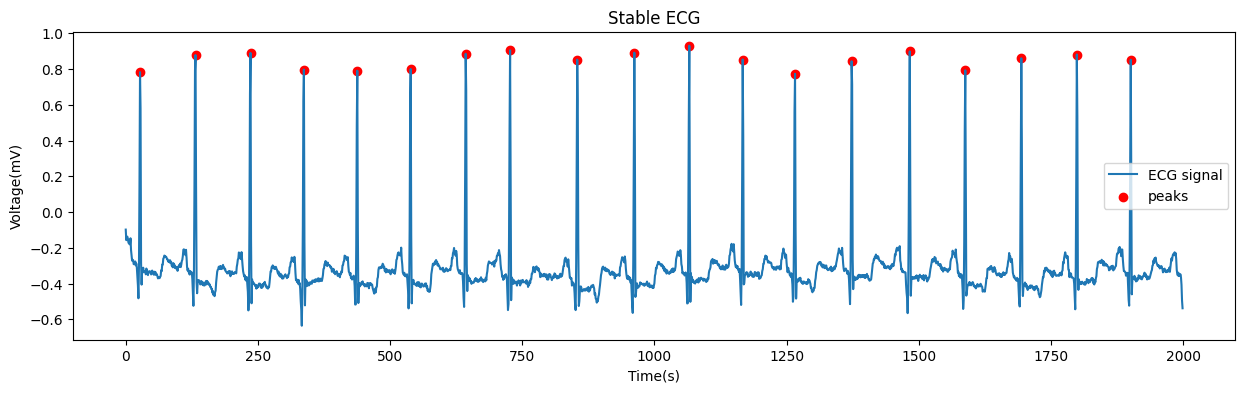

In [16]:
sample_data = np.stack(df_ecg_data['ecg_data'])

INDEX = 0
ecg = sample_data[:][INDEX]
n_values = np.arange(0, 2000, 1)
peaks_idx, _ = find_peaks(ecg, height=np.max(ecg)*0.2)
plt.figure(figsize=(15, 4))
plt.plot(n_values, ecg, label='ECG signal')
plt.scatter(peaks_idx, ecg[peaks_idx], color='red', label='peaks')
plt.xlabel("Time(s)")
plt.ylabel("Voltage(mV)")
plt.title("Stable ECG")
plt.legend()
plt.show()

But for the following ECG, it was not:

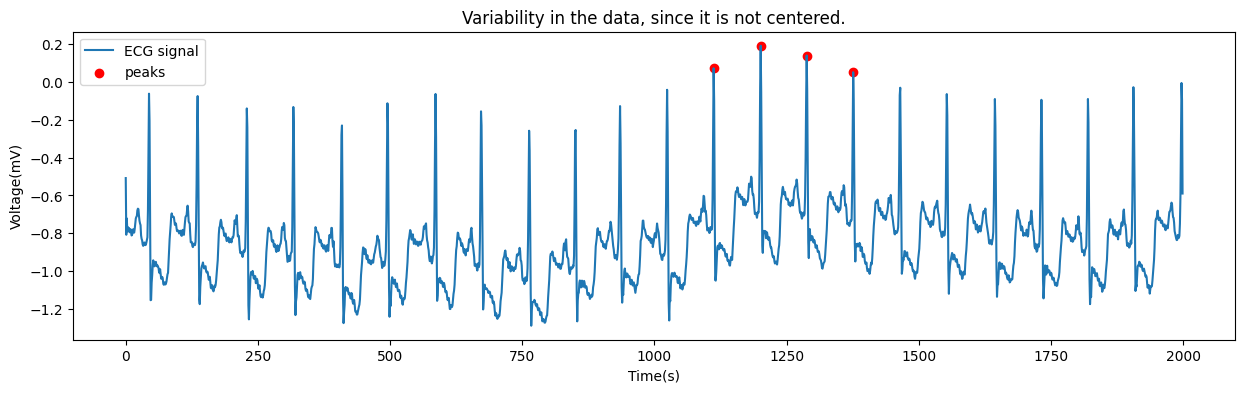

In [17]:
INDEX = 96
ecg = sample_data[:][INDEX]
n_values = np.arange(0, 2000, 1)
peaks_idx, _ = find_peaks(ecg, height=np.max(ecg)*0.2)
plt.figure(figsize=(15, 4))
plt.plot(n_values, ecg, label='ECG signal')
plt.scatter(peaks_idx, ecg[peaks_idx], color='red', label='peaks')
plt.xlabel("Time(s)")
plt.ylabel("Voltage(mV)")
plt.title("Variability in the data, since it is not centered.")
plt.legend()
plt.show()

This variability was quite bad for the `scipy`'s function `find_peaks`, since we could not find a rule that detected all peaks. Furthermore, there samples where multiple peaks were detected:

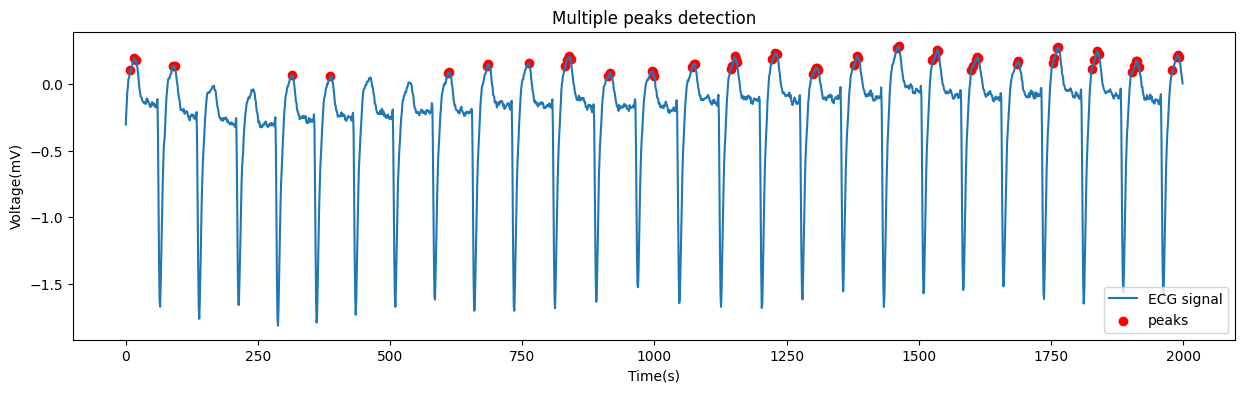

In [18]:
INDEX = 3700
ecg = sample_data[:][INDEX]
n_values = np.arange(0, 2000, 1)
peaks_idx, _ = find_peaks(ecg, height=np.max(ecg)*0.2)
plt.figure(figsize=(15, 4))
plt.plot(n_values, ecg, label='ECG signal')
plt.scatter(peaks_idx, ecg[peaks_idx], color='red', label='peaks')
plt.xlabel("Time(s)")
plt.ylabel("Voltage(mV)")
plt.title("Multiple peaks detection")
plt.legend()
plt.show()

Or sometimes, just one (abnormal) peak was detected:

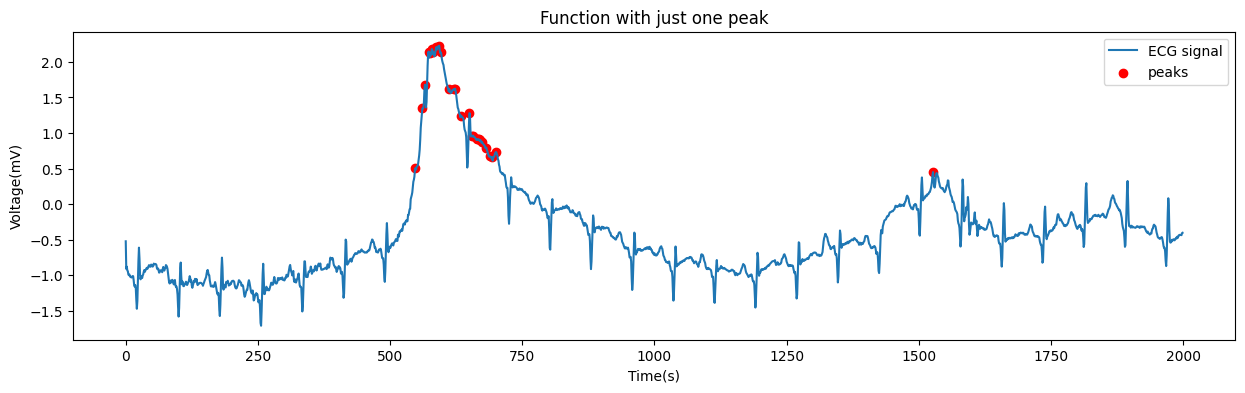

In [19]:
INDEX = 3200
ecg = sample_data[:][INDEX]
n_values = np.arange(0, 2000, 1)
peaks_idx, _ = find_peaks(ecg, height=np.max(ecg)*0.2)
plt.figure(figsize=(15, 4))
plt.plot(n_values, ecg, label='ECG signal')
plt.scatter(peaks_idx, ecg[peaks_idx], color='red', label='peaks')
plt.xlabel("Time(s)")
plt.ylabel("Voltage(mV)")
plt.title('Function with just one peak')
plt.legend()
plt.show()

Finally we opted for using a standard scaler, in order to try to normalize the data and had it centered at $\mu = 0$ and $\sigma = 1$. This mitigated the problem for some samples, but there were others where we could not detect the peaks. For some samples there were peaks that we upside down. This made us realize that, in order to detect them, we needed to flip the sample for `find_peaks` to detect it

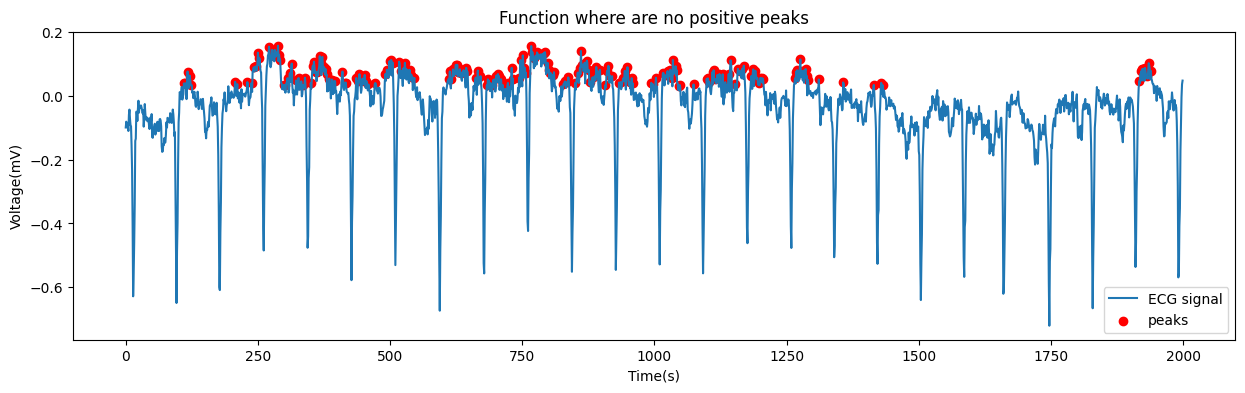

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

ecg_scaled = scaler.fit_transform(sample_data)

INDEX = 3400
ecg = ecg_scaled[:][INDEX]

n_values = np.arange(0, 2000, 1)
peaks_idx, _ = find_peaks(ecg, height=np.max(ecg)*0.2)
plt.figure(figsize=(15, 4))
plt.plot(n_values, ecg, label='ECG signal')
plt.scatter(peaks_idx, ecg[peaks_idx], color='red', label='peaks')
plt.xlabel("Time(s)")
plt.ylabel("Voltage(mV)")
plt.title("Function where are no positive peaks")
plt.legend()
plt.show()


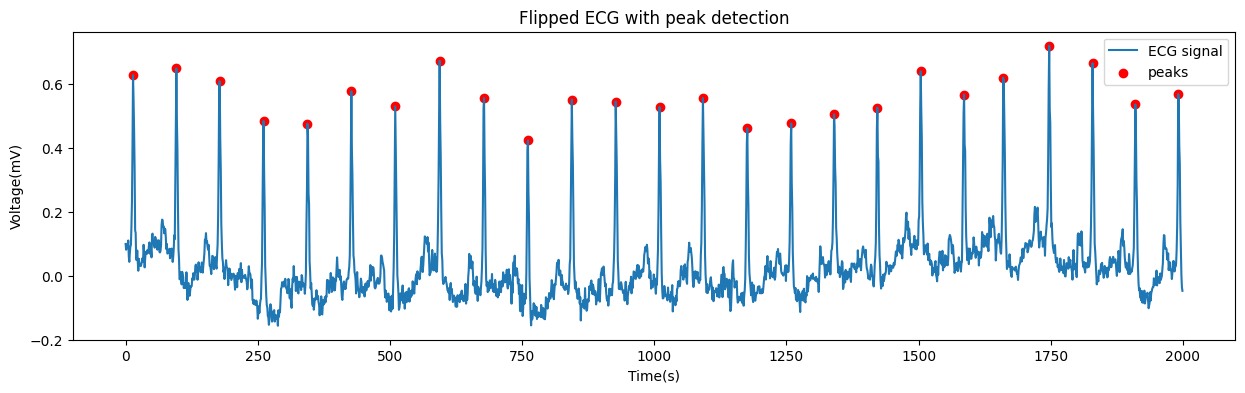

In [21]:
INDEX = 3400
ecg = ecg_scaled[:][INDEX]

peaks_idx, _ = find_peaks(-ecg, height=np.max(-ecg)*0.5)
plt.figure(figsize=(15, 4))
plt.plot(n_values, -ecg, label='ECG signal')
plt.scatter(peaks_idx, -ecg[peaks_idx], color='red', label='peaks')
plt.xlabel("Time(s)")
plt.ylabel("Voltage(mV)")
plt.title("Flipped ECG with peak detection")
plt.legend()
plt.show()

But even with all those transformations, there were peaks that were not yet detected. In order to solve this, we used an exponential function. Exponential functions have a numerical property that make large numbers even larger and small number even smaller. This could be also helpful in order to extract the peaks from our samples.

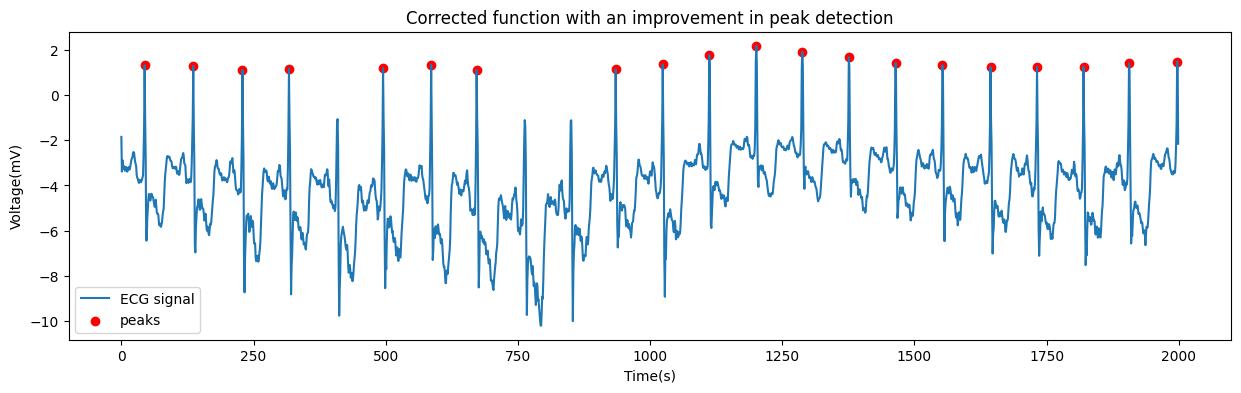

In [22]:
from feature_extraction import stretch_squeeze

INDEX = 96
ecg = ecg_scaled[:][INDEX]

ecg_stretched = stretch_squeeze(ecg, factor=1)
n_values = np.arange(0, 2000, 1)
peaks_idx, _ = find_peaks(ecg_stretched, height=np.max(ecg_stretched)*0.2)
plt.figure(figsize=(15, 4))
plt.plot(n_values, ecg_stretched, label='ECG signal')
plt.scatter(peaks_idx, ecg_stretched[peaks_idx], color='red', label='peaks')
plt.xlabel("Time(s)")
plt.ylabel("Voltage(mV)")
plt.title("Corrected function with an improvement in peak detection")
plt.legend()
plt.show()

It is worth to mention that this sample is the same as the second example (INDEX = 96) in this section, where almost no peaks were obtained. The standarization plus stretching of the data helped to mitigate a lot of peak detection problems.

After we extracted the peaks, we used the function `np.diff` to measure the distance between peaks. Each diference between the peaks, was the transformed from the index notation to time notation (discrete to continuos), using the sample rule $x[t] = x(nT)$. As n is the period of sampling (1/128) we could infer the distance in time between the peaks. In some cases, if peaks were not detected, we use as a countermeasure the replacement of the oulier distance by the median (since it was quite probable that the distribution was skewed) of the sample. We used `zcore` in order to do this. 

After that, we computed the mean, in order to have an average on the distance between peaks. Also we extracted other metrics such as the standard deviation. Also if, not a single peak was detected (after using all the transformations), we assigned `np.nan` to that sample, and after computing al the means, if we had any `np.nan` we computed the mean for each class of the samples and assigned to the corresponding sample.

After we computed the peak distance, we also computed the BPMs following the rule:

$$
    BPM = \frac{60·f_{s}}{\mu_{d_{peak}}}
$$

And additional metrics such as the standard deviation, max bpms, min bpms... etc.

All these functionalities are gathered in several functions in the `feature_extraction.py` script, where the functions are well documented with clear explanations of what each one does.

As we could see, the peak distance detection was a hard problem with not an unique solution. In the following sections it will be explained that the feature extraction was far from optimal, at least in our case.

In [23]:
from sklearn.preprocessing import StandardScaler

stacked_data = np.stack(df_ecg_data['ecg_data'])

scaler = StandardScaler()
scaler.fit(stacked_data)
stacked_data_t = scaler.transform(stacked_data)

In [24]:
from feature_extraction import avg_d_between_peaks, std_d_between_peaks, compute_bpm, compute_std_bpm, compute_max_bpm, compute_min_bpm

avg_d = np.apply_along_axis(avg_d_between_peaks, 1, stacked_data_t)
std_d = np.apply_along_axis(std_d_between_peaks, 1, stacked_data_t)
avg_bpm = np.apply_along_axis(compute_bpm, 1, stacked_data_t)
std_bpm = np.apply_along_axis(compute_std_bpm, 1, stacked_data_t)
max_bpm = np.apply_along_axis(compute_max_bpm, 1, stacked_data_t)
min_bpm = np.apply_along_axis(compute_min_bpm, 1, stacked_data_t)

df_ecg_data['avg_d_peaks'] = avg_d
df_ecg_data['std_d_peaks'] = std_d
df_ecg_data['avg_bpm'] = avg_bpm
df_ecg_data['std_bpm'] = std_bpm
df_ecg_data['max_bpm'] = max_bpm
df_ecg_data['min_bpm'] = min_bpm

Some nan's appeared caused by the topology of some samples, where there are one or none peaks detected, and we cannot compute the RR distances and the BPMs of each sample. In order to fill this nan's, we will use the mean for each class, to not affect the distribution.

In [25]:
df_ecg_data[df_ecg_data['avg_bpm'].isna()]

,ecg_data,class,sampled_from,n_chunk,deriv1,deriv2,avg_d_peaks,std_d_peaks,avg_bpm,std_bpm,max_bpm,min_bpm
284,"[-1.0662847235264512, -1.0309784560564395, -1....",1,9,29,"[0.035306267470011754, 0.014066313509724204, -...","[-0.02123995396028755, -0.021985976017364184, ...",NaN,NaN,NaN,NaN,NaN,NaN
615,"[-0.35306386911786447, -0.3534806814825913, -0...",1,20,8,"[-0.00041681236472684846, 0.009831688078735107...","[0.010248500443461955, -0.01052156999218841, -...",NaN,NaN,NaN,NaN,NaN,NaN
689,"[-0.06535958358140768, -0.020601499800116285, ...",1,22,18,"[0.0447580837812914, 0.02524105334887101, 0.01...","[-0.019517030432420385, -0.01389549396888979, ...",NaN,NaN,NaN,NaN,NaN,NaN
698,"[0.015763687778235974, 0.004570186342316302, -...",1,22,27,"[-0.011193501435919672, -0.026332662590596398,...","[-0.015139161154676726, -0.007598680044177543,...",NaN,NaN,NaN,NaN,NaN,NaN
700,"[-0.20523783375186522, -0.21692920708203706, -...",1,22,29,"[-0.01169137333017184, -0.0012903085596754627,...","[0.010401064770496377, 0.003754522633824371, 0...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4003,"[-0.8385836676884582, -0.8618173636519676, -0....",2,30,4,"[-0.023233695963509438, 0.006395170470559042, ...","[0.02962886643406848, 0.010756855468702364, -0...",NaN,NaN,NaN,NaN,NaN,NaN
4004,"[-0.2195897445696414, 0.6412007206669135, 1.07...",2,30,5,"[0.8607904652365549, 0.6483540194648197, -0.14...","[-0.21243644577173515, -0.5045516737018101, -0...",NaN,NaN,NaN,NaN,NaN,NaN
4493,"[-0.275, -0.265, -0.235, -0.225, -0.225, -0.22...",3,15,14,"[0.010000000000000009, 0.020000000000000018, 0...","[0.010000000000000009, 0.0049999999999999975, ...",NaN,NaN,NaN,NaN,NaN,NaN
4494,"[-0.345, -0.355, -0.355, -0.345, -0.345, -0.33...",3,15,15,"[-0.010000000000000009, -0.0050000000000000044...","[0.0050000000000000044, 0.007500000000000007, ...",NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
bpm_means = df_ecg_data.groupby('class')['avg_bpm'].mean()
bpm_std_means = df_ecg_data.groupby('class')['std_bpm'].mean()
bpm_max_means = df_ecg_data.groupby('class')['max_bpm'].mean()
bpm_min_means = df_ecg_data.groupby('class')['min_bpm'].mean()
avd_d_means = df_ecg_data.groupby('class')['avg_d_peaks'].mean()
std_d_means = df_ecg_data.groupby('class')['std_d_peaks'].mean()

df_ecg_data['avg_bpm'] = df_ecg_data.apply(lambda row: bpm_means[row['class']] if pd.isna(row['avg_bpm']) else row['avg_bpm'], axis=1)
df_ecg_data['std_bpm'] = df_ecg_data.apply(lambda row: bpm_std_means[row['class']] if pd.isna(row['std_bpm']) else row['std_bpm'], axis=1)
df_ecg_data['max_bpm'] = df_ecg_data.apply(lambda row: bpm_max_means[row['class']] if pd.isna(row['max_bpm']) else row['max_bpm'], axis=1)
df_ecg_data['min_bpm'] = df_ecg_data.apply(lambda row: bpm_min_means[row['class']] if pd.isna(row['min_bpm']) else row['min_bpm'], axis=1)
df_ecg_data['avg_d_peaks'] = df_ecg_data.apply(lambda row: avd_d_means[row['class']] if pd.isna(row['avg_d_peaks']) else row['avg_d_peaks'], axis=1)
df_ecg_data['std_d_peaks'] = df_ecg_data.apply(lambda row: std_d_means[row['class']] if pd.isna(row['std_d_peaks']) else row['std_d_peaks'], axis=1)
df_ecg_data

,ecg_data,class,sampled_from,n_chunk,deriv1,deriv2,avg_d_peaks,std_d_peaks,avg_bpm,std_bpm,max_bpm,min_bpm
0,"[-0.09785730141312626, -0.15688125766870917, -...",1,1,1,"[-0.059023956255582904, -0.019979427765969324,...","[0.03904452848961358, 0.0344381041616524, 0.00...",103.944444,2.717683,73.885623,1.922435,77.575758,69.818182
1,"[-0.3484112418649029, -0.02274587725720959, 0....",1,1,2,"[0.3256653646076933, 0.4678561896988175, 0.493...","[0.14219082509112418, 0.08400456235294218, -0....",103.631579,3.029861,74.108685,2.152329,77.575758,69.818182
2,"[-0.4360649375168176, -0.4460280919950408, -0....",1,1,3,"[-0.009963154478223213, -0.006462586527347575,...","[0.003500567950875638, 0.004696099230614967, 0...",103.666667,2.494438,74.083601,1.779547,76.800000,71.111111
3,"[-0.38340009514361517, -0.38383578522187806, -...",1,1,4,"[-0.00043569007826288475, 0.011976453998027381...","[0.012412144076290266, 0.005613563976551134, -...",103.944444,3.170563,73.885623,2.232525,76.800000,69.818182
4,"[-0.3231552247831461, -0.3163997523002529, -0....",1,1,5,"[0.00675547248289321, 0.0002321741644971398, -...","[-0.00652329831839607, -0.003785852940457468, ...",102.861111,2.623640,74.663786,1.895985,78.367347,71.111111
...,...,...,...,...,...,...,...,...,...,...,...,...
5179,"[-0.265, -0.265, -0.265, -0.185, -0.085, 0.275...",3,36,28,"[0.0, 0.0, 0.04000000000000001, 0.09, 0.23, 0....","[0.0, 0.020000000000000004, 0.045, 0.095, 0.11...",124.218750,7.472802,61.826415,3.692136,70.458716,54.857143
5180,"[0.065, 0.055, 0.135, 0.225, 0.275, 0.325, 0.3...",3,36,29,"[-0.010000000000000002, 0.035, 0.085, 0.07, 0....","[0.045000000000000005, 0.0475, 0.0175, -0.0175...",98.275000,4.526243,78.148054,3.465110,81.702128,71.111111
5181,"[-0.345, -0.365, -0.355, -0.355, -0.375, -0.34...",3,36,30,"[-0.020000000000000018, -0.0050000000000000044...","[0.015000000000000013, 0.012500000000000011, -...",102.578947,4.464076,74.869164,3.181183,80.842105,67.368421
5182,"[-0.005, 0.035, -0.045, 0.045, 0.015, -0.035, ...",3,36,31,"[0.04, -0.02, 0.0049999999999999975, 0.03, -0....","[-0.06, -0.0175, 0.025, -0.0225, -0.0024999999...",100.263158,4.375074,76.598425,3.319600,82.580645,70.458716


#### __3.2.1 Extracting FFT and DCT__

We are going to extract the FFT and DCT from the ecg_data. First of all, we compute the FFT of the ECG signals. Once we have stored the information in the fft column, we use it to compute the rest of the features except the dct, since this one needs the original signal in order to compute the result: $$dct(fft(20log(abs(ECG))))$$

In [27]:
df_ecg_data['fft'] = df_ecg_data['ecg_data'].apply(lambda x: fftshift(fft(x).real))
df_ecg_data['dct'] = df_ecg_data['ecg_data'].apply(lambda x: dct(fftshift(fft(20*np.log(np.abs(x)), n=2, norm='ortho'))))
df_ecg_data['dct_orig'] = df_ecg_data['fft'].apply(lambda x: dct(x, n=2, norm='ortho'))
df_ecg_data['dct_1coef'] = df_ecg_data['fft'].apply(lambda x: dct(x, n=2, norm='ortho')[0])

Once we have computed the signal, we have all the features set in order to make our classifications.

#### __3.3 Data Splitting for our classification__

Divide the data into training and test sets considering the first 21 examples of each class for training and the remaining 9 examples per testing.

In [28]:
range_class = range(1,4)
range_samples_per_class = range(1,31)
range_train_samples = range(1,22)
range_test_samples = range(22,31)

df_train = df_ecg_data[(df_ecg_data['sampled_from'].isin(range_train_samples))]
df_test = df_ecg_data[(df_ecg_data['sampled_from'].isin(range_test_samples))]

# dropping useless columns for classification
df_train = df_train.drop(columns=['sampled_from', 'n_chunk'])
df_test = df_test.drop(columns=['sampled_from', 'n_chunk'])

#### __3.4 Data analysis__

For our data analysis, we have used `seaborn` 's pairplot function, in order to see the correlation between our features and the target class. What we have found really shocked us at first. It seemed that no feature gave us any clue of discrimination for the classes. For obvious reasons, those features that involved arrays of any kind such as fft, dct, derivations were left out of the analysis.

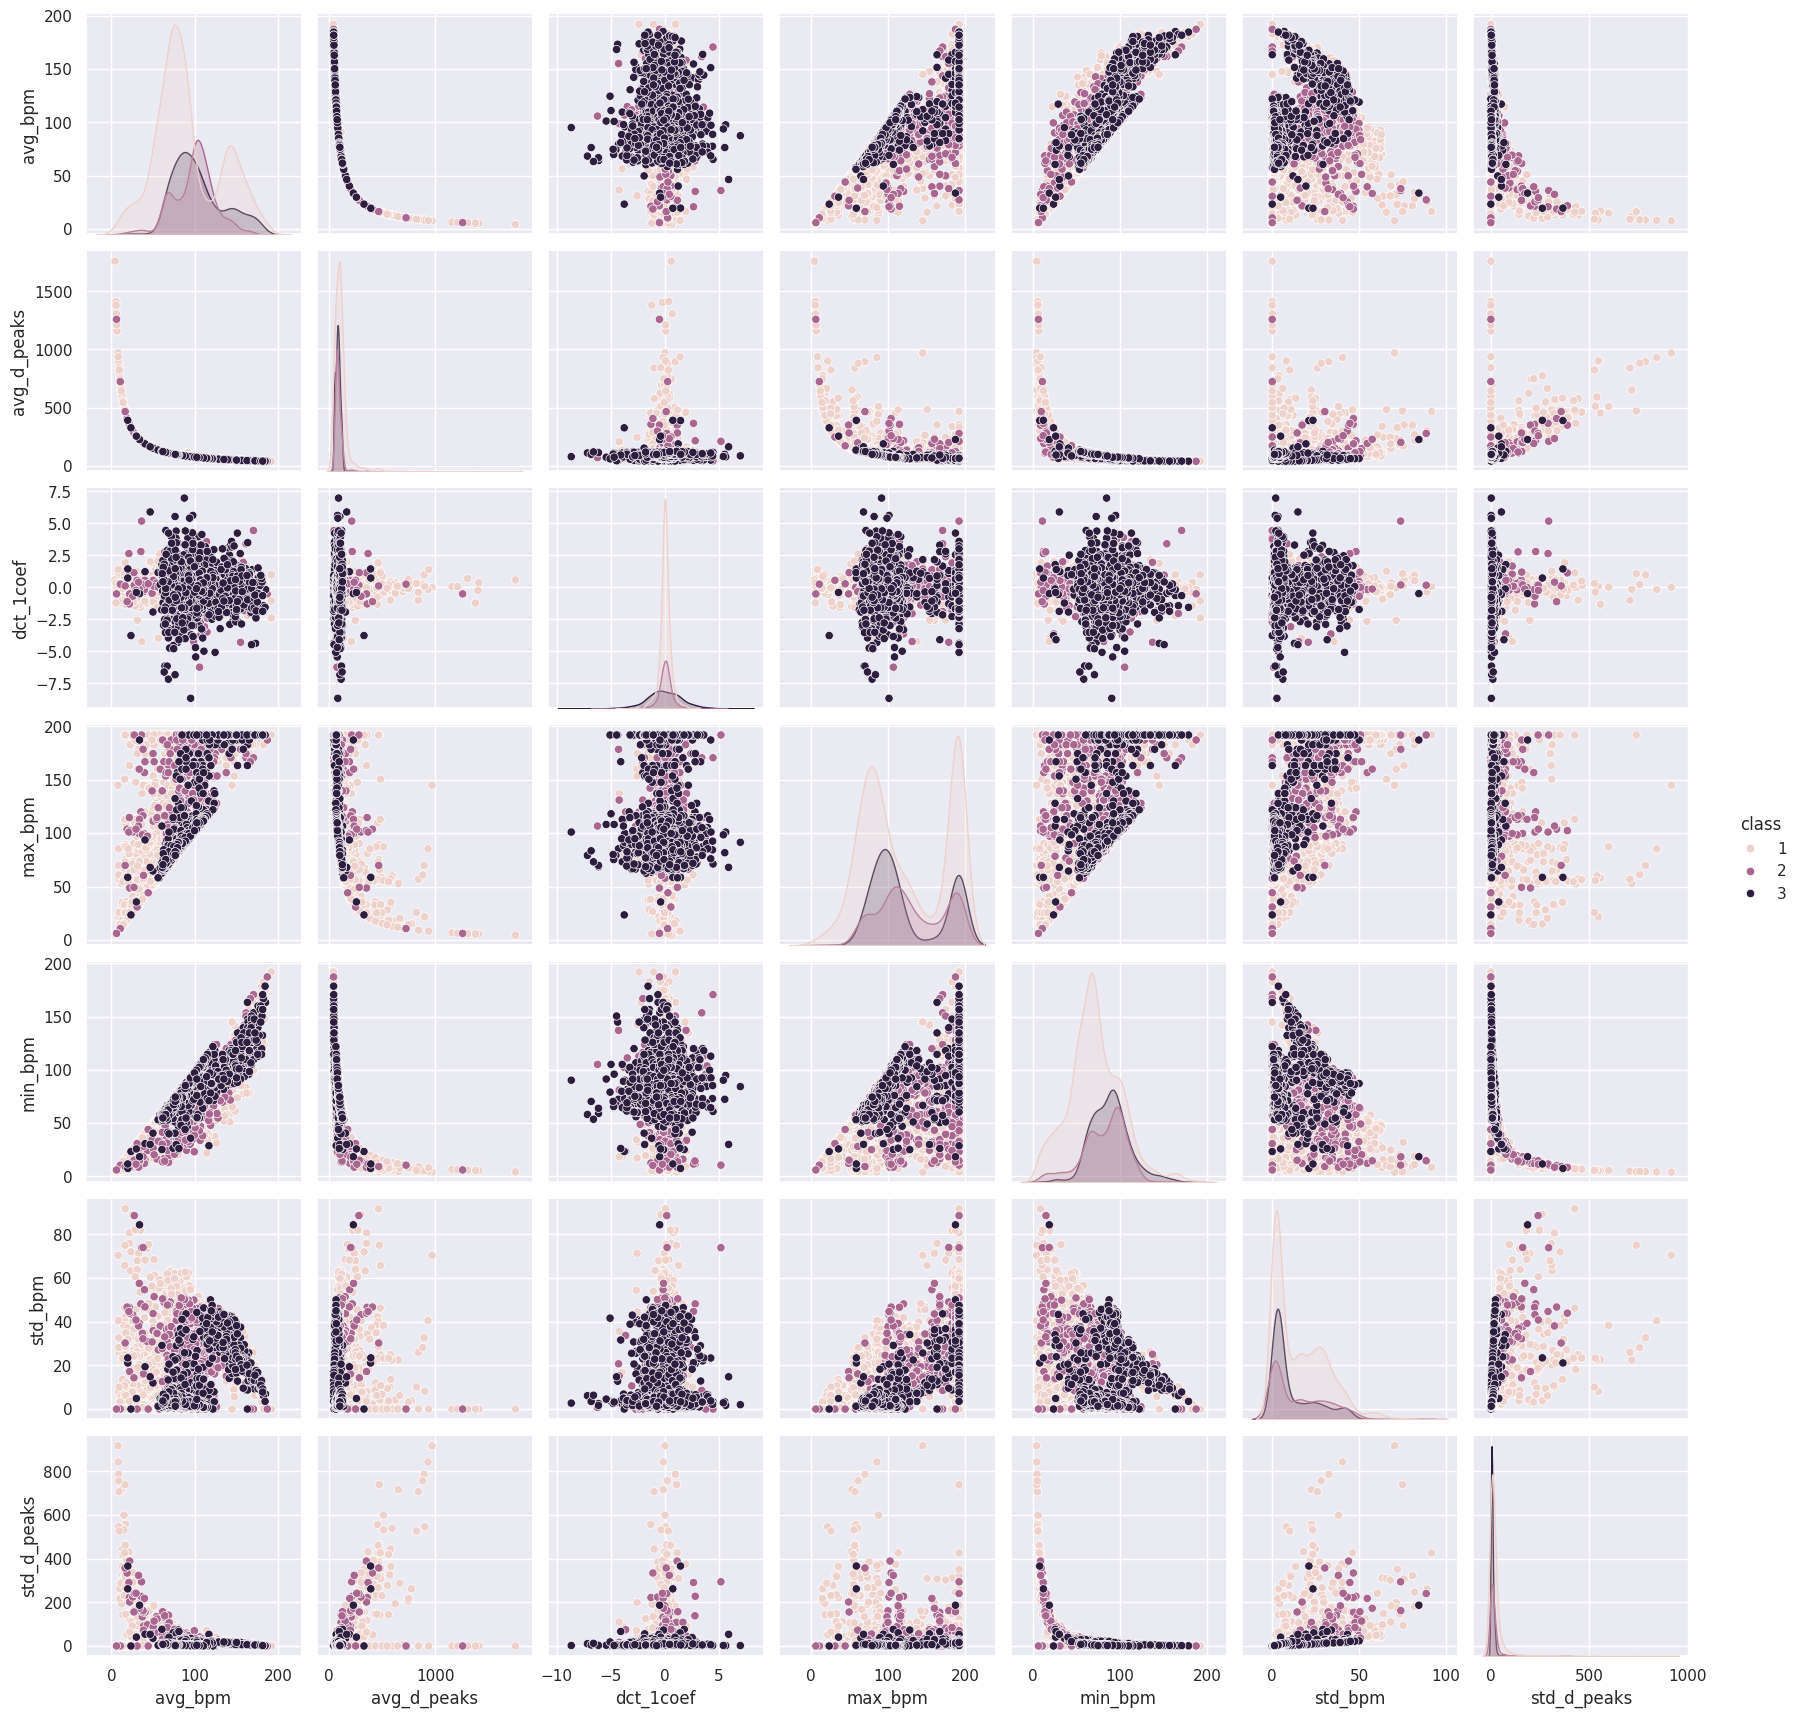

In [29]:
import seaborn as sns; sns.set()

df_pairplot = df_ecg_data[df_ecg_data.columns.difference(['deriv1', 'deriv2', 'fft', 'dct', 'ecg_data', 'dct_orig','sampled_from', 'n_chunk'])]
_ = sns.pairplot(df_pairplot, hue='class')

plt.show()

It seemed like as mentioned before, the feature extraction using the ecg was not as good as we thought. Spacially global features.

#### __Classification__

With our feature extraction completed (even knowing that there was a possibility of not getting the results we wanted), we tried to classify our samples. In order to do this used to approaches:

* __SVM__: We used the SVC Support Vector Classifier from the `sklearn` library.
* __Random Forest__: We used the a boosting algorithm called Random Forest from the `sklearn` library.
* __LSTM__: Since the data that we were using may had temporal dependencies, we thought of using a LSTM mixed with some features that we have extracted for classifying the samples. We used `keras` for this approach.

In [30]:
X_train, y_train =  df_train.loc[:, df_train.columns!='class'], df_train['class']
X_test, y_test =  df_test.loc[:, df_test.columns!='class'], df_test['class']

We split the data into three subsamples: 

* __Features data__: A dataframe with all the features extracted from the data. We left out the array-like features, since they could not be feed to the `skalearn` model.
* __ECG data__: Dataframe with all the raw values of the ECGs.
* __DCT data__: Dataframe with all the raw values of the DCTs.

In [31]:
X_train_singles_feat =  X_train.loc[:, X_train.columns.difference(['deriv1', 'deriv2', 'fft', 'dct', 'ecg_data', 'dct_orig'])]
X_test_singles_feat =  X_test.loc[:, X_test.columns.difference(['deriv1', 'deriv2', 'fft', 'dct', 'ecg_data', 'dct_orig'])]

X_train_ecg_data = np.stack(X_train['ecg_data'].values)
X_test_ecg_data = np.stack(X_test['ecg_data'].values)

X_train_dct = np.stack(X_train['dct_orig'].values)
X_test_dct= np.stack(X_test['dct_orig'].values)

#### __SVM__: Classic ML approach

We fed the models the features in train them, as the following code snippet:

In [32]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Constantes
C=15
KERNEL='rbf'

clf = make_pipeline(StandardScaler(), SVC(C=C, kernel=KERNEL, gamma='auto', probability=True))
clf.fit(X_train_singles_feat,y_train)

y_train_pred = clf.predict(X_train_singles_feat)
train_score = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test_singles_feat)
test_score = accuracy_score(y_test, y_test_pred)

print(f"Training score: {train_score} | Test score: {test_score}")

Training score: 0.78125 | Test score: 0.5370370370370371


We could see that, even though the training score was not bad, the test data was not good at all (as good as making decisions based on flipping a coin). We also tried a different approach. We fed the model with the whole ecg signal:

In [33]:
clf = make_pipeline(StandardScaler(), SVC(C=C, kernel=KERNEL, gamma='auto', probability=True))
clf.fit(X_train_ecg_data,y_train)

y_train_pred = clf.predict(X_train_ecg_data)
train_score = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test_ecg_data)
test_score = accuracy_score(y_test, y_test_pred)

print(f"Training score: {train_score} | Test score: {test_score}")

Training score: 0.9910714285714286 | Test score: 0.7337962962962963


The model seemed to overfit a lot, but it gave us an "acceptable" score.

#### __Random Forest__: Classic ML approach

We followed the same procedure as with the SVM, we fed the features data first:

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Constantes
C=15
KERNEL='rbf'

clf = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=16, random_state=0))
clf.fit(X_train_singles_feat,y_train)

y_train_pred = clf.predict(X_train_singles_feat)
train_score = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test_singles_feat)
test_score = accuracy_score(y_test, y_test_pred)

print(f"Training score: {train_score} | Test score: {test_score}")

Training score: 1.0 | Test score: 0.5347222222222222


And it seemed like the model overfitted, a lot. It is quite strange, since Random Forests are ussually models that tend to not overfit. We also tried as in the SVM to pass the whole ECG signal, but results were not worth mentioning.

#### __LSTM__: Capturing the temporal dependencies, the Deep Learning approach

Our reasoning behind using this model, was that ECGs are temporal signals. And LSTM are models that process sequences, so it would be a perfect match.

In [35]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM, Normalization,Dropout

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# It is possible to change the variables: units of layers, function loss, optimizer, epochs, and batch size
EPOCHS=10
BATCH_SIZE=64

2023-10-27 14:58:07.404094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 14:58:07.906137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1 Physical GPUs, 1 Logical GPUs


2023-10-27 14:58:08.408191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 14:58:08.412778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 14:58:08.413151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

We defined our model, normalizing the input data in order to achieve better results:

In [36]:
X_train= np.stack(X_train['ecg_data'].values)
X_test = np.stack(X_test['ecg_data'].values)

# Design the model
# Input: shape of the X_train_ecg_data 
ecg_input = keras.layers.Input(shape=(X_train.shape[1], 1), batch_size=BATCH_SIZE)
ecg_input_norm = Normalization(axis=1)(ecg_input)
x = LSTM(units=32, activation="tanh", return_sequences=False)(ecg_input_norm)
x = Dropout(0.2)(x)
x = Dense(units=32, activation="relu")(x)
output = Dense(3, activation="softmax")(x) # Output: three possibles targets (1,2,3)

model = keras.Model(ecg_input, output)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(64, 2000, 1)]           0         
                                                                 
 normalization (Normalizati  (64, 2000, 1)             4001      
 on)                                                             
                                                                 
 lstm (LSTM)                 (64, 32)                  4352      
                                                                 
 dropout (Dropout)           (64, 32)                  0         
                                                                 
 dense (Dense)               (64, 32)                  1056      
                                                                 
 dense_1 (Dense)             (64, 3)                   99        
                                                             

In [37]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/10


2023-10-27 14:58:10.414724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-27 14:58:10.507157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-27 14:58:10.508106: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x34a178d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-27 14:58:10.508118: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-10-27 14:58:10.511218: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-27 14:58:10.589880: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

32/32 [==============================] - 3s 35ms/step - loss: nan - accuracy: 0.0094
Epoch 2/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00


In [38]:
# Evaluate the model with loss and accuracy
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test loss: {loss} | Test accuracy: {accuracy}")

Test loss: nan | Test accuracy: 0.0


It seemed like our model could not learn anything. As we are writing this report, we still have no clue of why this is happening. We believe that we followed all the principles to make a okay pipeline and achieve some performance, but no acceptable results were obtained.

## __Conclusions__

The lab assignment has shown us how difficult feature extraction can really be. In the first exercise, we inferred the BPMs of some samples using only some basic principles, such as the Nyquist Theorem and transformations such as the Fourier Transform. In the third taks, we also dealed with the feature extraction problem, we then analyzed our features, and finally, we tried to used them as information for our models to classify. We certainly did not obtained the results that we expected, we have learn a lot about the whole "Data Science" pipeline.